# Lab-09: DBpedia14 classification with BERT

In Lab-03 we used linear text classification models (the perceptron, linear SVM, multinomial naive Bayes, softmax regression) on the DBpedia14 dataset. Recall that our best test accuracy was in the 92-93% range, and in lecture 08 we used a feed-forward NN with CBOW features to achieve ~97% test accuracy. Here we will use the BERT transformer model that was pretrained on vast amounts of text data to achieve >99% test accuracy with minimal hyperparameter tuning.

### Class labels

In [1]:
labels = {
    0: "Company",
    1: "EducationalInstitution",
    2: "Artist",
    3: "Athlete",
    4: "OfficeHolder",
    5: "MeanOfTransportation",
    6: "Building",
    7: "NaturalPlace",
    8: "Village",
    9: "Animal",
    10: "Plant",
    11: "Album",
    12: "Film",
    13: "WrittenWork"
}

K = len(labels)

## Download the dataset

In [2]:
# Colab provides limited GPU time (be mindful when increasing this number)
M = 30000

In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 15.6 MB/s 
     |████████████████████████████████| 163 kB 56.9 MB/s 
     |████████████████████████████████| 212 kB 44.4 MB/s 
     |████████████████████████████████| 115 kB 49.7 MB/s 
     |████████████████████████████████| 127 kB 55.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:
import datasets
import pandas as pd

df_train, df_test = datasets.load_dataset(
    'dbpedia_14', 
    split=['train[:80%]', 
           'test[80%:]']
)

df_train = df_train.to_pandas().sample(frac=1).reset_index(drop=True)[:int(0.8 * M)]
df_test = df_test.to_pandas().sample(frac=1).reset_index(drop=True)[:int(0.2 * M)]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/70000 [00:00<?, ? examples/s]

Dataset dbpedia_14 downloaded and prepared to /root/.cache/huggingface/datasets/dbpedia_14/dbpedia_14/2.0.0/01dab9e10d969eadcdbc918be5a09c9190a24caeae33b10eee8f367a1e3f1f0c. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

### (3 pts) Task 1: Analyze the data

a. What is the distribution of the labels in this data? 

*Hint*: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html

b. Compute the distribution of sentence length in the dataset

c. Are there any differences between the train and test sets? If so make any necessary changes to the train/test sets such that they look the same.

### (a)

In [ ]:
label_dist_train = df_train.label.value_counts().transform(lambda x: x/x.sum(), axis=0)

In [ ]:
label_dist_test = df_test.label.value_counts().transform(lambda x: x/x.sum(), axis=0)

<BarContainer object of 12 artists>

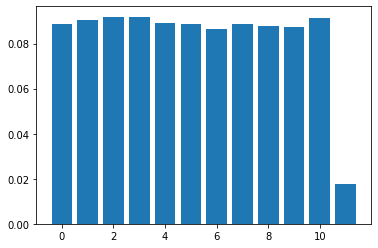

In [ ]:
import matplotlib.pyplot as plt
plt.bar(label_dist_train.index, label_dist_train)

<BarContainer object of 3 artists>

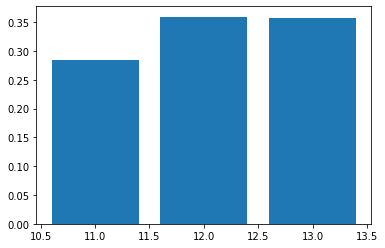

In [ ]:
plt.bar(label_dist_test.index, label_dist_test)

### (b)

In [ ]:
length_dist_train = df_train.content.transform(len).value_counts().transform(lambda x: x/x.sum(),axis=0)

In [ ]:
length_dist_test = df_test.content.transform(len).value_counts().transform(lambda x: x/x.sum(),axis=0)

<BarContainer object of 564 artists>

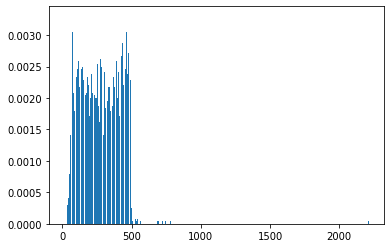

In [ ]:
plt.bar(length_dist_train.index, length_dist_train)

<BarContainer object of 487 artists>

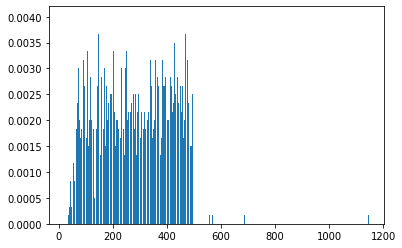

In [ ]:
plt.bar(length_dist_test.index, length_dist_test)

### (c)
The testing dataset contains less labels.

In [11]:
df_whole = pd.concat([df_train, df_test]).reset_index(drop=True)

In [12]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5)

In [13]:
for train_index, test_index in kf.split(df_whole, df_whole.label):
    df_train = df_whole.loc[train_index]
    df_test = df_whole.loc[test_index]
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
df_train.label.value_counts().transform(lambda x: x/x.sum(), axis=0)

4     0.072750
13    0.072625
1     0.072375
10    0.072333
3     0.072333
6     0.071750
8     0.071708
0     0.070958
12    0.070875
11    0.070833
7     0.070833
5     0.070667
2     0.070625
9     0.069333
Name: label, dtype: float64

In [ ]:
df_test.label.value_counts().transform(lambda x: x/x.sum(), axis=0)

2     0.073500
3     0.073500
10    0.073167
1     0.072167
12    0.072000
4     0.071333
13    0.071333
7     0.071167
5     0.071000
11    0.071000
0     0.070833
8     0.070167
9     0.069833
6     0.069000
Name: label, dtype: float64

## Train BERT on DBpedia14

Here you will use Google CoLab, which provides free (but limited) use of hosted GPU instances.

Before doing this, take a look at the leaderboard for DBpedia14: https://paperswithcode.com/dataset/dbpedia. You'll find various transformers (including BERT) at the top. Here we will use a smaller version of BERT called DistilBERT which reduces the computational overhead with only marginal performance degradation, and only two training epochs over an abridged version of the dataset.

### Google CoLab

To complete the tasks below you will need to login to a Google account and then go here: https://colab.research.google.com. Then do the following:

1. End any existing CoLab sessions that you have running

2. Click on the `Upload` tab and upload this file

3. Click on `Runtime -> Change runtime type` and select `GPU`

### Install packages

In [5]:
!pip install -q transformers torch

     |████████████████████████████████| 5.3 MB 14.0 MB/s 
     |████████████████████████████████| 7.6 MB 54.1 MB/s 


### Restart runtime

After running the cell above, click `Runtime -> Restart runtime`. This only needs to be done one time per session.

### Training Hyperparameters

In [6]:
batch_size = 32
epochs = 2
lr_init = 1e-5
max_len = 512
warmup_steps = 3

### (7 pts) Task 2: Create batched inputs using Huggingface's DistilBERT tokenizer 

In [7]:
from typing import List, Tuple
import torch
from transformers import DistilBertTokenizerFast
from transformers.tokenization_utils_base import BatchEncoding

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [8]:
def batch_data(data: pd.DataFrame, bsize: int, epochs=1) -> List[Tuple[BatchEncoding, List[int], List[str]]]:
    """
    This Function accepts a Pandas DataFrame and a batch size and returns
    a list of training 'batches', each of which is a tuple of:
        ( X, Y, s )
    where
        X: BatchEncoding ∈ R^(`bsize` x `T_max` x `D`)    inputs
        Y: torch.Tensor ∈ Z^(`bsize` x `1`)               ground truth labels
        s: List[str] w/ len `bsize`                       sentences (i.e., documents)
    
    Note: refer to the `DistilBertTokenizerFast.batch_encode_plus()` method to produce X
    """
    for epoch in range(epochs):
      for i in range(0, len(data), bsize):
        s = data.loc[i : i + bsize - 1]["content"].tolist()
        Y = torch.Tensor(data.loc[i : i + bsize - 1]["label"].tolist())
        X = tokenizer.batch_encode_plus(s, truncation=True, padding='longest', return_tensors='pt', return_attention_mask=True, max_length=max_len)
        yield (X, Y, s)
    

### Create train/test splits

In [14]:
import numpy as np
label_counts = df_train.groupby('label').count().content
label_freq = label_counts/label_counts.sum()
min_label_count = label_counts.min()
df_train_sort = df_train.sort_values('label').reset_index(drop=True)
batch_label_size = np.zeros(len(labels))
for i in range(1, len(labels)):
  label_counts[i] += label_counts[i-1]
label_index = np.zeros(len(labels))
label_index[1:] = label_counts[:len(labels)-1]
tmp_index = (np.expand_dims(label_index.astype(int), axis=0) + np.expand_dims(np.arange(min_label_count).astype(int),axis=1)).flatten()
tmp_res = np.setdiff1d(np.arange(len(df_train)).astype(int), tmp_index)
np.random.shuffle(tmp_res)
df_train = df_train_sort.loc[np.concatenate((tmp_index,tmp_res))].reset_index(drop=True)

In [15]:
train_batches = batch_data(df_train, bsize=batch_size)
test_batches = batch_data(df_test, bsize=batch_size)

### Load pretrained Distilbert model

This cell uses the `DistilBertForSequenceClassification` class, which is a convenience wrapper that places a classification head onto the DistilBert language model. 

In [16]:
from tqdm import tqdm
import torch
from transformers import DistilBertForSequenceClassification, \
  AdamW, get_linear_schedule_with_warmup, \
  get_polynomial_decay_schedule_with_warmup, \
  get_constant_schedule_with_warmup, \
  get_cosine_schedule_with_warmup
# Transformer model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased', 
    num_labels=K, 
    output_hidden_states=True)

# The torch `device` on which to execute the model computation
if torch.cuda.is_available():
    device = torch.device('cuda:0') # GPU
else:
    device = torch.device('cpu') # CPU
model.to(device)

# The gradient descent optimizer used for fine tuning
optimizer = AdamW(model.parameters(), lr=lr_init)

# The gradient descent learning rate
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, 
    num_training_steps=int(len(df_train)/batch_size)*epochs
)

# scheduler = get_polynomial_decay_schedule_with_warmup(
#     optimizer, num_warmup_steps=warmup_steps, 
#     num_training_steps=int(len(df_train)/batch_size)*epochs,
#     power=2,
#     lr_end = 1e-06
# )

# scheduler = get_constant_schedule_with_warmup(
#     optimizer, num_warmup_steps=warmup_steps
# )

# scheduler = get_cosine_schedule_with_warmup(
#     optimizer, num_warmup_steps=warmup_steps, 
#     num_training_steps=int(len(df_train)/batch_size)*epochs,
# )

# Control the loss function
loss_fn = torch.nn.BCEWithLogitsLoss(reduction = 'mean')

Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.wei

### (10 pts) Task 3: Implement a training loop from scratch

Here you need to:

1. Implement the `runner()` method below
2. Train the DistilBert model on the training set
3. Compute and print out the loss, accuracy, and f1-score of the trained model on the train and tests sets
4. Provide a brief summary of the results and place them in context to other modeling approaches (e.g.word2vec from lecture 03, the CBOW NN from lecture 08).

*Note: You're encouraged to use the Huggingface documentation to complete this task!*

*Note: This should take about 20 minutes on CoLabs K80 GPUs*

In [17]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.5 MB/s 


In [18]:
from datasets import load_metric
from evaluate import load
from transformers import AdamW
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import numpy as np
def runner(batches, train=True, cls_embed_maxStep=10):
    """
    This function accepts a list of batches (i.e., the output of batch_data())
    and returns a tuple consisting of:
        (predictions, cls-embeddings, mean-loss, accuracy, f1-score)
    where
        preditions: List[pred for each input]
        cls-embeddings: List[bert's cls embeddings for each input]
        mean-loss: mean loss computed over data in batches
        mean-accuracy: mean accuracy computed over data in batches
        mean-f1-score: mean f1 score computed over data in batches
    """
    predictions = []
    cls_embed = []
    true_labels = []
    loss_list = []

    acc_metric = load('accuracy')
    f1_metric = load('f1')

    for i, batch in tqdm(enumerate(batches)):
      #if i > 10:
      #  break
      ### extract batch encodings & labels
      input = batch[0]
      batch_labels = batch[1]
      input.to(device)
      
      ### convert int labels into onehot encoding for output.loss computing
      onehot_labels = torch.zeros((batch_labels.shape[0], K), device=device)
      for j in range(batch_labels.shape[0]):
        onehot_labels[j, int(batch_labels[j].item())] = 1.0

      ### if not in training process we don't need grads
      if not train:
        with torch.no_grad():
          output = model(**input, labels=onehot_labels, output_hidden_states=True)
          logits = output.logits
          predicted_token_id = logits.argmax(axis=-1).tolist()
          loss = output.loss
          loss_list.append(loss.detach().cpu())
      else:
        output = model(**input, labels=onehot_labels, output_hidden_states=True)
        logits = output.logits
        predicted_token_id = logits.argmax(axis=-1)
        loss = output.loss
        loss_list.append(loss.detach().cpu())
        #print(loss.item())
        #print(loss_fn(logits, onehot_labels).item())
        loss.backward()
        optimizer.step()
        scheduler.step()
        # predicted_token_id = []
        # for j in range(batch_labels.shape[0]):
        #   output = model(input['input_ids'][[j],:], attention_mask=input['attention_mask'][[j],:], labels=onehot_labels[[j],:], output_hidden_states=True)
        #   logits = output.logits
        #   predicted_token_id.append(logits.argmax(axis=-1).item())
        #   loss = output.loss
        #   loss.backward()
        #   optimizer.step()
        #   scheduler.step()
        #   loss_list.append(loss.detach().cpu())
          


      ### reserve pred, true_labels
      predictions.extend(predicted_token_id)
      true_labels.extend(batch_labels.tolist())

      ### print accuracy every 50 batches
      if (i+1)%50 == 0:
        if train:
          acc_metric.add_batch(predictions=predicted_token_id, references=batch_labels.tolist())
          print(acc_metric.compute())
          print(scheduler.get_last_lr())

      ### len(output.hidden_states)==7 which means our distilbertmodel has 7 hidden layers
      ### last_hidden_states contains last-layer-params of word embeddings which are fed to decoders directly
      ### last_hidden_states.shape is states of first layer(batchsize:33, max_sentence_length in batch, length of embeddings:768)
      if i <= cls_embed_maxStep:
        last_hidden_states = output.hidden_states[-1]

        ### extract the first token of hidden_states which are 
        for j in range(last_hidden_states.shape[0]):
          tmp_embed = last_hidden_states[j,0,:]
          cls_embed.append(tmp_embed)

      ### release memory
      # del input
      # del batch_labels
      # del onehot_labels
      # del output
      # del logits
      # if (i <= cls_embed_maxStep):
      #   del last_hidden_states
      #   del tmp_embed
      # torch.cuda.empty_cache() 
      #print(' CUDA Reserved Memory:{:.2f} G'.format(torch.cuda.memory_allocated(0)/1024.0/1024.0/1024.0))
    acc_metric.add_batch(predictions=predictions, references=true_labels)
    acc = acc_metric.compute()
    f1_metric.add_batch(predictions=predictions, references=true_labels)
    f1 = f1_metric.compute(average='weighted')
    if len(loss_list) > 0:
      mean_loss = np.array(loss_list).mean()
    else:
      mean_loss = 0
    return (predictions, cls_embed, mean_loss, acc, f1)

In [ ]:
print(' CUDA Reserved Memory:{:.2f} G'.format(torch.cuda.memory_allocated(0)/1024.0/1024.0/1024.0))

 CUDA Reserved Memory:1.12 G


In [19]:
#df_train_whole = pd.concat([df_train]*epochs).reset_index(drop=True)
train_batches = batch_data(df_train, bsize=batch_size, epochs=epochs)
result = runner(train_batches, train=True)

50it [00:18,  3.35it/s]

{'accuracy': 0.09375}
[9.686038744154977e-06]


100it [00:33,  3.09it/s]

{'accuracy': 0.0625}
[9.352037408149633e-06]


150it [00:49,  3.41it/s]

{'accuracy': 0.21875}
[9.018036072144289e-06]


200it [01:04,  3.06it/s]

{'accuracy': 0.34375}
[8.684034736138945e-06]


250it [01:20,  3.13it/s]

{'accuracy': 0.5625}
[8.350033400133602e-06]


300it [01:39,  3.04it/s]

{'accuracy': 0.6875}
[8.016032064128258e-06]


350it [01:56,  2.59it/s]

{'accuracy': 0.78125}
[7.682030728122914e-06]


400it [02:12,  3.13it/s]

{'accuracy': 0.90625}
[7.3480293921175695e-06]


450it [02:28,  3.06it/s]

{'accuracy': 0.90625}
[7.014028056112225e-06]


500it [02:45,  3.01it/s]

{'accuracy': 0.8125}
[6.680026720106881e-06]


550it [03:01,  3.15it/s]

{'accuracy': 1.0}
[6.346025384101538e-06]


600it [03:18,  3.09it/s]

{'accuracy': 0.9375}
[6.0120240480961935e-06]


650it [03:35,  2.93it/s]

{'accuracy': 0.78125}
[5.678022712090849e-06]


700it [03:52,  2.83it/s]

{'accuracy': 0.96875}
[5.344021376085505e-06]


750it [04:09,  2.77it/s]

{'accuracy': 0.8125}
[5.01002004008016e-06]


800it [04:25,  3.14it/s]

{'accuracy': 0.96875}
[4.676018704074817e-06]


850it [04:41,  2.87it/s]

{'accuracy': 0.9375}
[4.342017368069472e-06]


900it [04:58,  3.23it/s]

{'accuracy': 1.0}
[4.008016032064129e-06]


950it [05:14,  2.91it/s]

{'accuracy': 0.96875}
[3.6740146960587848e-06]


1000it [05:31,  3.09it/s]

{'accuracy': 0.96875}
[3.3400133600534405e-06]


1050it [05:48,  3.17it/s]

{'accuracy': 1.0}
[3.0060120240480967e-06]


1100it [06:05,  2.63it/s]

{'accuracy': 1.0}
[2.6720106880427525e-06]


1150it [06:21,  3.11it/s]

{'accuracy': 0.96875}
[2.3380093520374083e-06]


1200it [06:38,  3.00it/s]

{'accuracy': 0.96875}
[2.0040080160320645e-06]


1250it [06:54,  3.00it/s]

{'accuracy': 1.0}
[1.6700066800267203e-06]


1300it [07:10,  3.17it/s]

{'accuracy': 0.96875}
[1.3360053440213763e-06]


1350it [07:28,  3.10it/s]

{'accuracy': 1.0}
[1.0020040080160322e-06]


1400it [07:44,  3.01it/s]

{'accuracy': 0.96875}
[6.680026720106881e-07]


1450it [08:01,  2.83it/s]

{'accuracy': 0.96875}
[3.3400133600534407e-07]


1500it [08:18,  3.01it/s]

{'accuracy': 0.9375}
[0.0]


In [20]:
train_batches = batch_data(df_train, bsize=batch_size)
predictions_train, cls_embed_train, mean_loss_train, acc_train, f1_train = runner(train_batches, train=False)

750it [01:34,  7.94it/s]


In [21]:
[mean_loss_train, acc_train, f1_train]

[0.010837621, {'accuracy': 0.9878333333333333}, {'f1': 0.9878298492713233}]

In [22]:
test_batches = batch_data(df_test, bsize=batch_size)
predictions_test, cls_embed_test, mean_loss_test, acc_test, f1_test = runner(test_batches, train=False)

188it [00:23,  8.09it/s]


In [23]:
[mean_loss_test, acc_test, f1_test]

[0.016919566, {'accuracy': 0.9775}, {'f1': 0.9774644347334015}]

In [24]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(df_train['label'].tolist(),predictions_train)
acc = np.diag(conf_mat/np.sum(conf_mat, axis=1))
num = np.sum(conf_mat, axis=1)
[(acc[i], num[i]) for i in range(len(labels))]

[(0.9714119019836639, 1714),
 (0.9895531050493326, 1723),
 (0.9788208357183743, 1747),
 (0.994175888177053, 1717),
 (0.9816737935247404, 1637),
 (0.9970691676436108, 1706),
 (0.9709887507400828, 1689),
 (0.9947429906542056, 1712),
 (0.9982658959537573, 1730),
 (0.9915158371040724, 1768),
 (0.9900990099009901, 1717),
 (0.9970845481049563, 1715),
 (0.9866511897852582, 1723),
 (0.9870740305522914, 1702)]

In [25]:
conf_mat = confusion_matrix(df_test['label'].tolist(),predictions_test)
acc = np.diag(conf_mat/np.sum(conf_mat, axis=1))
num = np.sum(conf_mat, axis=1)
[(acc[i], num[i]) for i in range(len(labels))]

[(0.9324009324009324, 429),
 (0.9814385150812065, 431),
 (0.9633867276887872, 437),
 (0.993006993006993, 429),
 (0.9731051344743277, 409),
 (0.9836065573770492, 427),
 (0.9644549763033176, 422),
 (0.9649532710280374, 428),
 (1.0, 432),
 (0.9886877828054299, 442),
 (0.9883449883449883, 429),
 (0.9953271028037384, 428),
 (0.974477958236659, 431),
 (0.9812206572769953, 426)]

In [ ]:
# def pretty_size(size):
# 	"""Pretty prints a torch.Size object"""
# 	assert(isinstance(size, torch.Size))
# 	return " × ".join(map(str, size))

# def dump_tensors(gpu_only=True):
# 	"""Prints a list of the Tensors being tracked by the garbage collector."""
# 	import gc
# 	total_size = 0
# 	for obj in gc.get_objects():
# 		try:
# 			if torch.is_tensor(obj):
# 				if not gpu_only or obj.is_cuda:
# 					print("%s:%s%s %s" % (type(obj).__name__, 
# 										  " GPU" if obj.is_cuda else "",
# 										  " pinned" if obj.is_pinned else "",
# 										  pretty_size(obj.size())))
# 					total_size += obj.numel()
# 			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
# 				if not gpu_only or obj.is_cuda:
# 					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
# 												   type(obj.data).__name__, 
# 												   " GPU" if obj.is_cuda else "",
# 												   " pinned" if obj.data.is_pinned else "",
# 												   " grad" if obj.requires_grad else "", 
# 												   " volatile" if obj.volatile else "",
# 												   pretty_size(obj.data.size())))
# 					total_size += obj.data.numel()
# 		except Exception as e:
# 			pass        
# 	print("Total size:", total_size)

### (2 pts) Task 4: test your model on new string

Make up (or find) a document that maps to one of the 14 classes in DBpedia14. Is the model's prediction in agreement with your label assignment? The cell below contains some helper code to get you started. To compute the model prediction, reuse the `batch_data()` and `runner()` functions.

In [26]:
import numpy as np
import pandas as pd

example_text = """Her is a 2013 American science-fiction romantic drama film written, 
directed, and produced by Spike Jonze. It marks Jonze's solo screenwriting debut. 
The film follows Theodore Twombly (Joaquin Phoenix), a man who develops a relationship 
with Samantha (Scarlett Johansson), an artificially intelligent virtual assistant 
personified through a female voice."""

example_ground_truth_label = 12 # "film"

df = pd.DataFrame({'content': [example_text], 
                   'label': example_ground_truth_label, 
                   'title': None})

In [28]:
example_batch = batch_data(df, bsize=1)
predictions_example, cls_embed_example, mean_loss_example, acc_example, f1_example = runner(example_batch, train=False)

1it [00:00, 39.67it/s]


In [29]:
acc_example

{'accuracy': 1.0}

### (3 pts) Task 5: Extract the document embeddings and visualize them in Tensorboard Projector

### TSV helper functions from Lecture 05

In [ ]:
def save_matrix(matrix, fpath):
    D1, D2 = matrix.shape
    tsv = ""
    for i in range(D1):
        for j in range(D2):
            tsv += str(matrix[i, j]) + '\t'
        tsv = tsv.strip('\t') + '\n'
    tsv = tsv.strip('\n')
    with open(fpath, "w") as fd:
        fd.write(tsv)

def save_docs(docs, labels, fpath):
    tsv = "document\tlabel\n"
    for doc, label in zip(docs, labels):
        tsv += doc.lower().strip() + '\t' + label + '\n'
    tsv = tsv.strip('\n')
    with open(fpath, "w") as fd:
        fd.write(tsv)

### Extract embeddings

In [31]:
example_batch = batch_data(df, bsize=1)
for i, batch in tqdm(enumerate(example_batch)):
  input = batch[0]
  input.to(device)
  with torch.no_grad():
    output = model(**input, output_hidden_states=True)

1it [00:00, 45.10it/s]


In [41]:
token_embeddings = np.squeeze(output.hidden_states[-1].detach().cpu().numpy(), axis=0)

### Visualize embeddings

The embeddings and text can be saved in tsv format and uploaded here  https://projector.tensorflow.org/ for visualization. Choose the tSNE algorithm.

In [43]:
from sklearn.manifold import TSNE
embeddings = TSNE(n_components=2).fit_transform(token_embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


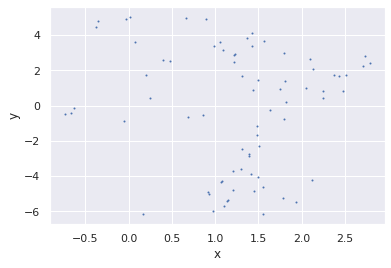

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = "darkgrid")
fig = plt.figure()
ax = plt.axes()
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(embeddings[:,0], embeddings[:,1], s=1)
plt.show()